In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
df = pd.read_pickle('datasets/features-label-text-represented-subset.pkl')
df_copy = df.copy()

In [3]:
df_copy.shape[0]

43290

Retrieve train and test file_ids

In [4]:
train_ids = pd.read_csv('train-test-ids/train-ids.csv')
test_ids = pd.read_csv('train-test-ids/test-ids.csv')

In [5]:
train_data = df_copy[df_copy['file_id'].isin(train_ids['file_id'].astype(str))]
test_data = df_copy[df_copy['file_id'].isin(test_ids['file_id'].astype(str))]

In [6]:
train_data.shape

(32113, 10)

In [7]:
test_data.shape

(11177, 10)

In [8]:
def get_test_mse(model, test_features, test_label):
    test_pred = model.predict(test_features)
    return mean_squared_error(test_label, test_pred)

def get_test_mae(model, test_features, test_label):
    test_pred = model.predict(test_features)
    return mean_absolute_error(test_label, test_pred)

# n: length of test data
# p: number of predictors
def get_test_adj_r2(model, test_features, test_label, n, p):
    test_pred = model.predict(test_features)
    r2 = r2_score(test_label, test_pred)
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return adjusted_r2

# Part 1: ROE only

Model1.0 ROE_t -> ROE_t+1

In [9]:
train_features_m1_0 = train_data['roe'].to_numpy().reshape(-1, 1)
train_label_m1_0 = train_data['roe_next_year'].to_numpy()

test_features_m1_0 = test_data['roe'].to_numpy().reshape(-1, 1)
test_label_m1_0 = test_data['roe_next_year'].to_numpy()

In [10]:
# normalisation
train_features_m1_0_norm = (train_features_m1_0 - np.mean(train_features_m1_0, axis=0)) / np.std(train_features_m1_0, axis=0)
test_features_m1_0_norm = (test_features_m1_0 - np.mean(test_features_m1_0, axis=0)) / np.std(test_features_m1_0, axis=0)

Model1.0 Linear regression

In [16]:
model1_lr = LinearRegression()
model1_lr.fit(train_features_m1_0_norm, train_label_m1_0)

LinearRegression()

In [18]:
print(model1_lr.coef_)

[0.14966002]


In [13]:
# save model as binary file
pickle.dump(model1_lr, open('finalised-models/model1-0-lr.pkl', 'wb'))

In [19]:
model1_lr_mse = get_test_mse(model1_lr,
             test_features_m1_0_norm,
             test_label_m1_0)
model1_lr_mse

0.04110550206121985

In [40]:
model1_0_lr_pkl = pickle.load(open('finalised-models/model1-0-lr.pkl', 'rb'))
get_test_mae(
    model1_0_lr_pkl,
    test_features_m1_0_norm,
    test_label_m1_0
)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


0.12787995360521998

In [41]:
n = len(test_data)
p = 1
get_test_adj_r2(
    model1_0_lr_pkl,
    test_features_m1_0_norm,
    test_label_m1_0,
    n,
    p
)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


0.36595381199155896

Model1.0 Ridge regression

In [21]:
model1_ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 3, 5, 10])
model1_ridge.fit(train_features_m1_0_norm, train_label_m1_0)

RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 3, 5, 10])

In [22]:
print(model1_ridge.alpha_)

5.0


In [20]:
# save model as binary file
pickle.dump(model1_ridge, open('finalised-models/model1-0-ridge.pkl', 'wb'))

In [23]:
model1_ridge_mse = get_test_mse(model1_ridge,
             test_features_m1_0_norm,
             test_label_m1_0)
model1_ridge_mse

0.041105715643722916

In [2]:
model1_0_ridge_pkl = pickle.load(open('finalised-models/model1-0-ridge.pkl', 'rb'))
get_test_mae(
    model1_0_ridge_pkl,
    test_features_m1_0_norm,
    test_label_m1_0
)

NameError: name 'get_test_mae' is not defined

In [42]:
get_test_adj_r2(
    model1_0_ridge_pkl,
    test_features_m1_0_norm,
    test_label_m1_0,
    n,
    p
)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RidgeCV was fitted with feature names
  warnings.warn(


0.36595051751355523

Model1.0 Decision tree

In [25]:
model1_0_dt = DecisionTreeRegressor(max_depth=3)
model1_0_dt.fit(train_features_m1_0_norm, train_label_m1_0)

DecisionTreeRegressor(max_depth=3)

In [26]:
get_test_mse(model1_0_dt,
             test_features_m1_0_norm,
             test_label_m1_0)

0.04025985359738235

In [27]:
# tune hyperparameters
dt_params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'splitter': ['best', 'random']
}

model1_0_dt_tune = GridSearchCV(estimator=model1_0_dt,
                                param_grid=dt_params,
                                n_jobs=-1)
model1_0_dt_tune.fit(train_features_m1_0_norm, train_label_m1_0)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/l

GridSearchCV(estimator=DecisionTreeRegressor(max_depth=3), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [100, 200, 300, 400, 500],
                         'splitter': ['best', 'random']})

In [28]:
model1_0_dt_tune.best_params_

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 500,
 'splitter': 'best'}

In [29]:
model1_0_dt_best = model1_0_dt_tune.best_estimator_
model1_0_dt_best_mse = get_test_mse(model1_0_dt_best,
             test_features_m1_0_norm,
             test_label_m1_0)
model1_0_dt_best_mse

0.03973743466742333

In [31]:
pickle.dump(model1_0_dt_best, open('finalised-models/model1-0-dt.pkl', 'wb'))

In [12]:
model1_0_dt_pkl = pickle.load(open('finalised-models/model1-0-dt.pkl', 'rb'))

In [43]:
get_test_mae(
    model1_0_dt_pkl,
    test_features_m1_0_norm,
    test_label_m1_0
)

0.12357554572350844

In [44]:
get_test_adj_r2(
    model1_0_dt_pkl,
    test_features_m1_0_norm,
    test_label_m1_0,
    n,
    p
)

0.3870560458162051

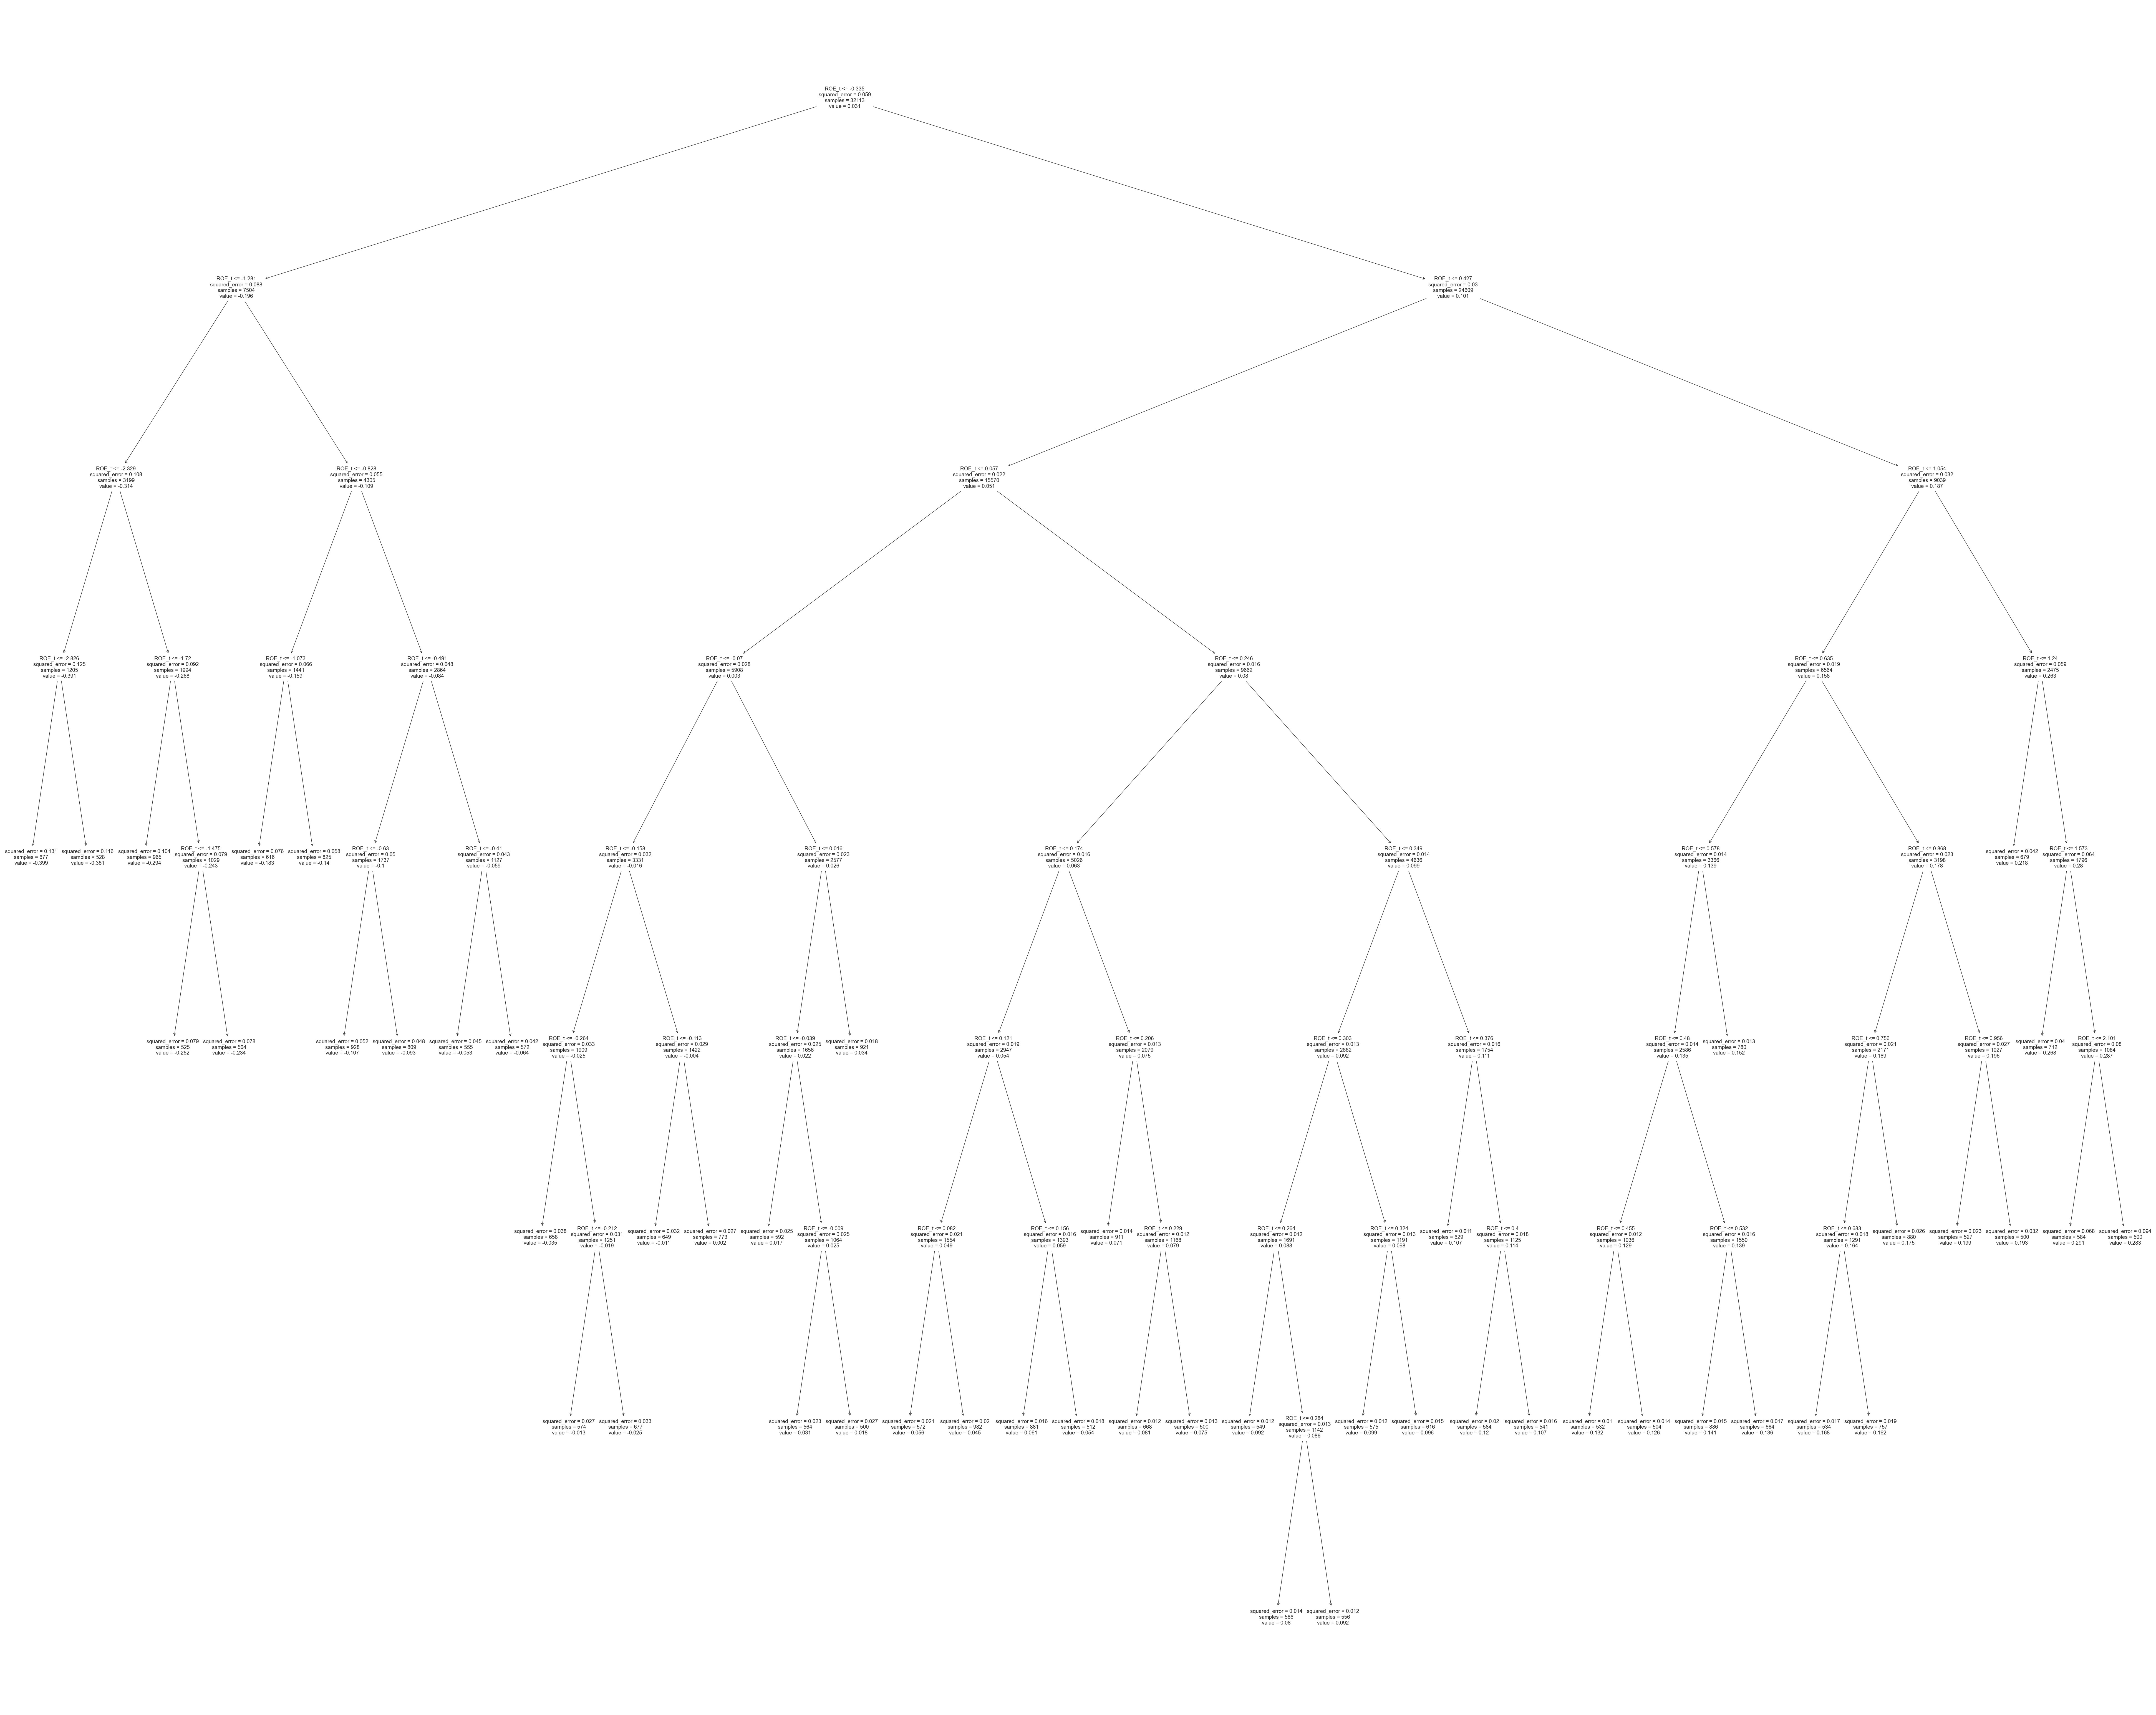

In [16]:
fig = plt.figure(figsize=(100, 80))

features_names = ['ROE_t']
_ = tree.plot_tree(model1_0_dt_pkl, feature_names=features_names)

Model1.0 Gradient boosting

In [32]:
model1_0_gb = GradientBoostingRegressor()
model1_0_gb.fit(train_features_m1_0_norm, train_label_m1_0)

GradientBoostingRegressor()

In [33]:
get_test_mse(model1_0_gb,
             test_features_m1_0_norm,
             test_label_m1_0)

0.03984759230843476

In [34]:
# tune hyperparameters
gb_params = {
    'n_estimators': [50, 100, 150],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [3, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10, 20, 50, 100],
    'min_samples_leaf': [100, 200, 300, 400, 500],
    'learning_rate': [0.1, 0.01, 0.001]
}

# use RandomizedSearchCV for save computation
model1_0_gb_tune = RandomizedSearchCV(estimator=model1_0_gb,
                                      param_distributions=gb_params,
                                      random_state=42,
                                      n_iter=100,
                                      n_jobs=-1)
model1_0_gb_tune.fit(train_features_m1_0_norm, train_label_m1_0)

RandomizedSearchCV(estimator=GradientBoostingRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.01, 0.001],
                                        'max_depth': [3, 5, 10, 20, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [100, 200, 300, 400,
                                                             500],
                                        'min_samples_split': [2, 5, 10, 20, 50,
                                                              100],
                                        'n_estimators': [50, 100, 150]},
                   random_state=42)

In [35]:
model1_0_gb_tune.best_params_

{'n_estimators': 100,
 'min_samples_split': 50,
 'min_samples_leaf': 500,
 'max_features': 'log2',
 'max_depth': 3,
 'learning_rate': 0.1}

In [36]:
model1_0_gb_best = model1_0_gb_tune.best_estimator_
model1_0_gb_best_mse = get_test_mse(model1_0_gb_best,
             test_features_m1_0_norm,
             test_label_m1_0)
model1_0_gb_best_mse

0.03969555841474671

In [38]:
pickle.dump(model1_0_gb_best, open('finalised-models/model1-0-gb.pkl', 'wb'))

In [33]:
model1_0_gb_pkl = pickle.load(open('finalised-models/model1-0-gb.pkl', 'rb'))
get_test_mae(
    model1_0_gb_pkl,
    test_features_m1_0_norm,
    test_label_m1_0
)

0.12336874328274017

In [37]:
n = test_data.shape[0]
p = 1
get_test_adj_r2(
    model1_0_gb_pkl,
    test_features_m1_0_norm,
    test_label_m1_0,
    n,
    p
)

0.3877019807165535

# Part 2: ROE + LMD tone

Model1.1 ROE_t, tone_t -> ROE_t+1

In [19]:
train_features_m1_1 = train_data[['roe', 'tone']].to_numpy()
train_label_m1_1 = train_data['roe_next_year'].to_numpy()

test_features_m1_1 = test_data[['roe', 'tone']].to_numpy()
test_label_m1_1 = test_data['roe_next_year'].to_numpy()

In [20]:
# normalisation
train_features_m1_1_norm = (train_features_m1_1 - np.mean(train_features_m1_1, axis=0)) / np.std(train_features_m1_1, axis=0)
test_features_m1_1_norm = (test_features_m1_1 - np.mean(test_features_m1_1, axis=0)) / np.std(test_features_m1_1, axis=0)

Model1.1 Linear regression

In [41]:
model1_1_lr = LinearRegression()
model1_1_lr.fit(train_features_m1_1_norm, train_label_m1_1)

LinearRegression()

In [42]:
print(model1_1_lr.coef_)

[ 1.49660961e-01 -3.69320415e-05]


In [43]:
model1_1_lr_mse = get_test_mse(model1_1_lr,
             test_features_m1_1_norm,
             test_label_m1_0)
model1_1_lr_mse

0.041105450419457415

In [57]:
pickle.dump(model1_1_lr, open('finalised-models/model1-1-lr.pkl', 'wb'))

In [23]:
model1_1_lr_pkl = pickle.load(open('finalised-models/model1-1-lr.pkl', 'rb'))
print('MAE: ', get_test_mae(
    model1_1_lr_pkl,
    test_features_m1_1_norm,
    test_label_m1_1
))

n = test_data.shape[0]
p = 2
print('Adjusted R^2: ', get_test_adj_r2(
    model1_1_lr_pkl,
    test_features_m1_1_norm,
    test_label_m1_1,
    n,
    p
))

MAE:  0.1278792971843574
Adjusted R^2:  0.365897865637678


Model1.1 Ridge regression

In [45]:
model1_1_ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 3, 5, 10, 15, 20])
model1_1_ridge.fit(train_features_m1_1_norm, train_label_m1_1)

RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 3, 5, 10, 15, 20])

In [50]:
print(model1_1_ridge.alpha_)

10.0


In [47]:
model1_1_ridge_mse = get_test_mse(model1_1_ridge,
             test_features_m1_1_norm,
             test_label_m1_1)
model1_1_ridge_mse

0.0411058802037298

In [56]:
pickle.dump(model1_1_ridge, open('finalised-models/model1-1-ridge.pkl', 'wb'))

In [24]:
model1_1_ridge_pkl = pickle.load(open('finalised-models/model1-1-ridge.pkl', 'rb'))
print('MAE: ', get_test_mae(
    model1_1_ridge_pkl,
    test_features_m1_1_norm,
    test_label_m1_1
))

n = test_data.shape[0]
p = 2
print('Adjusted R^2: ', get_test_adj_r2(
    model1_1_ridge_pkl,
    test_features_m1_1_norm,
    test_label_m1_1,
    n,
    p
))

MAE:  0.12788467379307408
Adjusted R^2:  0.3658912356866215


Model1.1 Decision tree

In [52]:
model1_1_dt = DecisionTreeRegressor(max_depth=3)
model1_1_dt.fit(train_features_m1_1_norm, train_label_m1_1)

DecisionTreeRegressor(max_depth=3)

In [54]:
get_test_mse(model1_1_dt,
             test_features_m1_1_norm,
             test_label_m1_1)

0.04025985359738235

In [55]:
# tune hyperparameters
dt_params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [100, 200, 300, 500, 800],
    'max_features': ['auto', 'sqrt', 'log2'],
    'splitter': ['best', 'random']
}

model1_1_dt_tune = GridSearchCV(estimator=model1_1_dt,
                                param_grid=dt_params,
                                n_jobs=-1)
model1_1_dt_tune.fit(train_features_m1_1_norm, train_label_m1_1)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/l

GridSearchCV(estimator=DecisionTreeRegressor(max_depth=3), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [100, 200, 300, 500, 800],
                         'splitter': ['best', 'random']})

In [56]:
model1_1_dt_tune.best_params_

{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 300,
 'splitter': 'best'}

In [57]:
model1_1_dt_best = model1_1_dt_tune.best_estimator_
model1_1_dt_best_mse = get_test_mse(model1_1_dt_best,
             test_features_m1_1_norm,
             test_label_m1_1)
model1_1_dt_best_mse

0.03982317763148287

In [59]:
pickle.dump(model1_1_dt_best, open('finalised-models/model1-1-dt.pkl', 'wb'))

In [25]:
model1_1_dt_pkl = pickle.load(open('finalised-models/model1-1-dt.pkl', 'rb'))
print('MAE: ', get_test_mae(
    model1_1_dt_pkl,
    test_features_m1_1_norm,
    test_label_m1_1
))

n = test_data.shape[0]
p = 2
print('Adjusted R^2: ', get_test_adj_r2(
    model1_1_dt_pkl,
    test_features_m1_1_norm,
    test_label_m1_1,
    n,
    p
))

MAE:  0.12362128701326498
Adjusted R^2:  0.38567850064817544


Model1.1 Gradient boosting

In [60]:
model1_1_gb = GradientBoostingRegressor()
model1_1_gb.fit(train_features_m1_1_norm, train_label_m1_1)

GradientBoostingRegressor()

In [61]:
get_test_mse(model1_1_gb,
             test_features_m1_1_norm,
             test_label_m1_1)

0.039802706362996

In [62]:
# tune hyperparameters
gb_params = {
    'n_estimators': [50, 100, 150],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [2, 3, 5, 10, 20, 50],
    'min_samples_split': [5, 10, 20, 50, 100, 200],
    'min_samples_leaf': [100, 200, 300, 500, 800],
    'learning_rate': [0.1, 0.01, 0.001]
}

# use RandomizedSearchCV for save computation
model1_1_gb_tune = RandomizedSearchCV(estimator=model1_1_gb,
                                      param_distributions=gb_params,
                                      random_state=42,
                                      n_iter=100,
                                      n_jobs=-1)
model1_1_gb_tune.fit(train_features_m1_1_norm, train_label_m1_1)

RandomizedSearchCV(estimator=GradientBoostingRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.01, 0.001],
                                        'max_depth': [2, 3, 5, 10, 20, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [100, 200, 300, 500,
                                                             800],
                                        'min_samples_split': [5, 10, 20, 50,
                                                              100, 200],
                                        'n_estimators': [50, 100, 150]},
                   random_state=42)

In [63]:
model1_1_gb_tune.best_params_

{'n_estimators': 100,
 'min_samples_split': 200,
 'min_samples_leaf': 500,
 'max_features': 'sqrt',
 'max_depth': 2,
 'learning_rate': 0.1}

In [64]:
model1_1_gb_best = model1_1_gb_tune.best_estimator_
model1_1_gb_best_mse = get_test_mse(model1_1_gb_best,
             test_features_m1_1_norm,
             test_label_m1_1)
model1_1_gb_best_mse

0.039721535932453166

In [66]:
pickle.dump(model1_1_gb_best, open('finalised-models/model1-1-gb.pkl', 'wb'))

In [47]:
model1_1_gb_pkl = pickle.load(open('finalised-models/model1-1-gb.pkl', 'rb'))
get_test_mae(
    model1_1_gb_pkl,
    test_features_m1_1_norm,
    test_label_m1_1
)

0.1235197078067574

In [50]:
p = 2
get_test_adj_r2(
    model1_1_gb_pkl,
    test_features_m1_1_norm,
    test_label_m1_1,
    n,
    p
)

0.387246448879791

# Part 3: ROE + word embedding

Model1.2 ROE_t, text_vector_t -> ROE_t+1

In [26]:
# features concatenation
train_features_m1_2 = np.concatenate((np.array(train_data['text_vector'].tolist()), train_data['roe'].values.reshape(-1, 1)), axis=1)
train_label_m1_2 = train_data['roe_next_year'].values

test_features_m1_2 = np.concatenate((np.array(test_data['text_vector'].tolist()), test_data['roe'].values.reshape(-1, 1)), axis=1)
test_label_m1_2 = test_data['roe_next_year'].values

In [27]:
# normalisation
train_features_m1_2_norm = (train_features_m1_2 - np.mean(train_features_m1_2, axis=0)) / np.std(train_features_m1_2, axis=0)
test_features_m1_2_norm = (test_features_m1_2 - np.mean(test_features_m1_2, axis=0)) / np.std(test_features_m1_2, axis=0)

Model1.2 Linear regression

In [69]:
model1_2_lr = LinearRegression()
model1_2_lr.fit(train_features_m1_2_norm, train_label_m1_2)

LinearRegression()

In [70]:
model1_2_lr_mse = get_test_mse(model1_2_lr,
             test_features_m1_2_norm,
             test_label_m1_2)
model1_2_lr_mse

0.039135531641187174

In [111]:
pickle.dump(model1_2_lr, open('finalised-models/model1-2-lr.pkl', 'wb'))

In [30]:
model1_2_lr_pkl = pickle.load(open('finalised-models/model1-2-lr.pkl', 'rb'))
print('MAE: ', get_test_mae(
    model1_2_lr_pkl,
    test_features_m1_2_norm,
    test_label_m1_2
))

n = test_data.shape[0]
p = test_features_m1_2.shape[1]
print('Adjusted R^2: ', get_test_adj_r2(
    model1_2_lr_pkl,
    test_features_m1_2_norm,
    test_label_m1_2,
    n,
    p
))

MAE:  0.12385724902872594
Adjusted R^2:  0.3908896576509554


Model1.2 Ridge regression

In [72]:
model1_2_ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 3, 5, 10])
model1_2_ridge.fit(train_features_m1_2_norm, train_label_m1_2)

RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 3, 5, 10])

In [73]:
print(model1_2_ridge.alpha_)

3.0


In [74]:
model1_2_ridge_mse = get_test_mse(model1_2_ridge,
             test_features_m1_2_norm,
             test_label_m1_2)
model1_2_ridge_mse

0.039142331358085154

In [119]:
pickle.dump(model1_2_ridge, open('finalised-models/model1-2-ridge.pkl', 'wb'))

In [3]:
model1_2_ridge_pkl = pickle.load(open('finalised-models/model1-2-ridge.pkl', 'rb'))

In [31]:
print('MAE: ', get_test_mae(
    model1_2_ridge_pkl,
    test_features_m1_2_norm,
    test_label_m1_2
))

n = test_data.shape[0]
p = test_features_m1_2.shape[1]
print('Adjusted R^2: ', get_test_adj_r2(
    model1_2_ridge_pkl,
    test_features_m1_2_norm,
    test_label_m1_2,
    n,
    p
))

MAE:  0.12382248049462417
Adjusted R^2:  0.3907838260009454


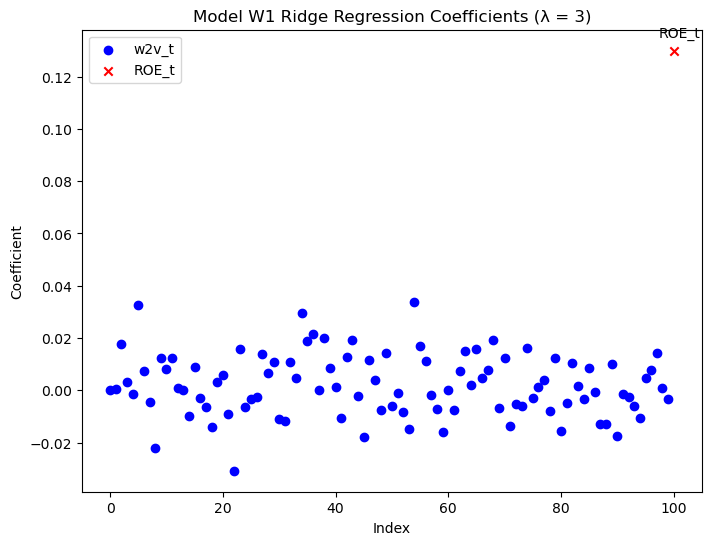

In [9]:
coefs = model1_2_ridge_pkl.coef_
coefs_w2v = coefs[:-1]
coefs_roe = coefs[-1:]


plt.figure(figsize=(8, 6))
plt.scatter(range(len(coefs_w2v)), coefs_w2v, c='blue', label='w2v_t', marker='o')
plt.scatter(range(len(coefs_w2v), len(coefs_w2v) + len(coefs_roe)), coefs_roe, c='red', label='ROE_t', marker='x')
plt.annotate('ROE_t', (101, coefs_roe[0]), textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('Index')
plt.ylabel('Coefficient')
plt.title('Model W1 Ridge Regression Coefficients (λ = 3)')
plt.legend()
plt.show()

Model1.2 Decision tree

In [76]:
# with trial hyperparameters
model1_2_dt = DecisionTreeRegressor(max_depth=3)
model1_2_dt.fit(train_features_m1_2_norm, train_label_m1_2)

DecisionTreeRegressor(max_depth=3)

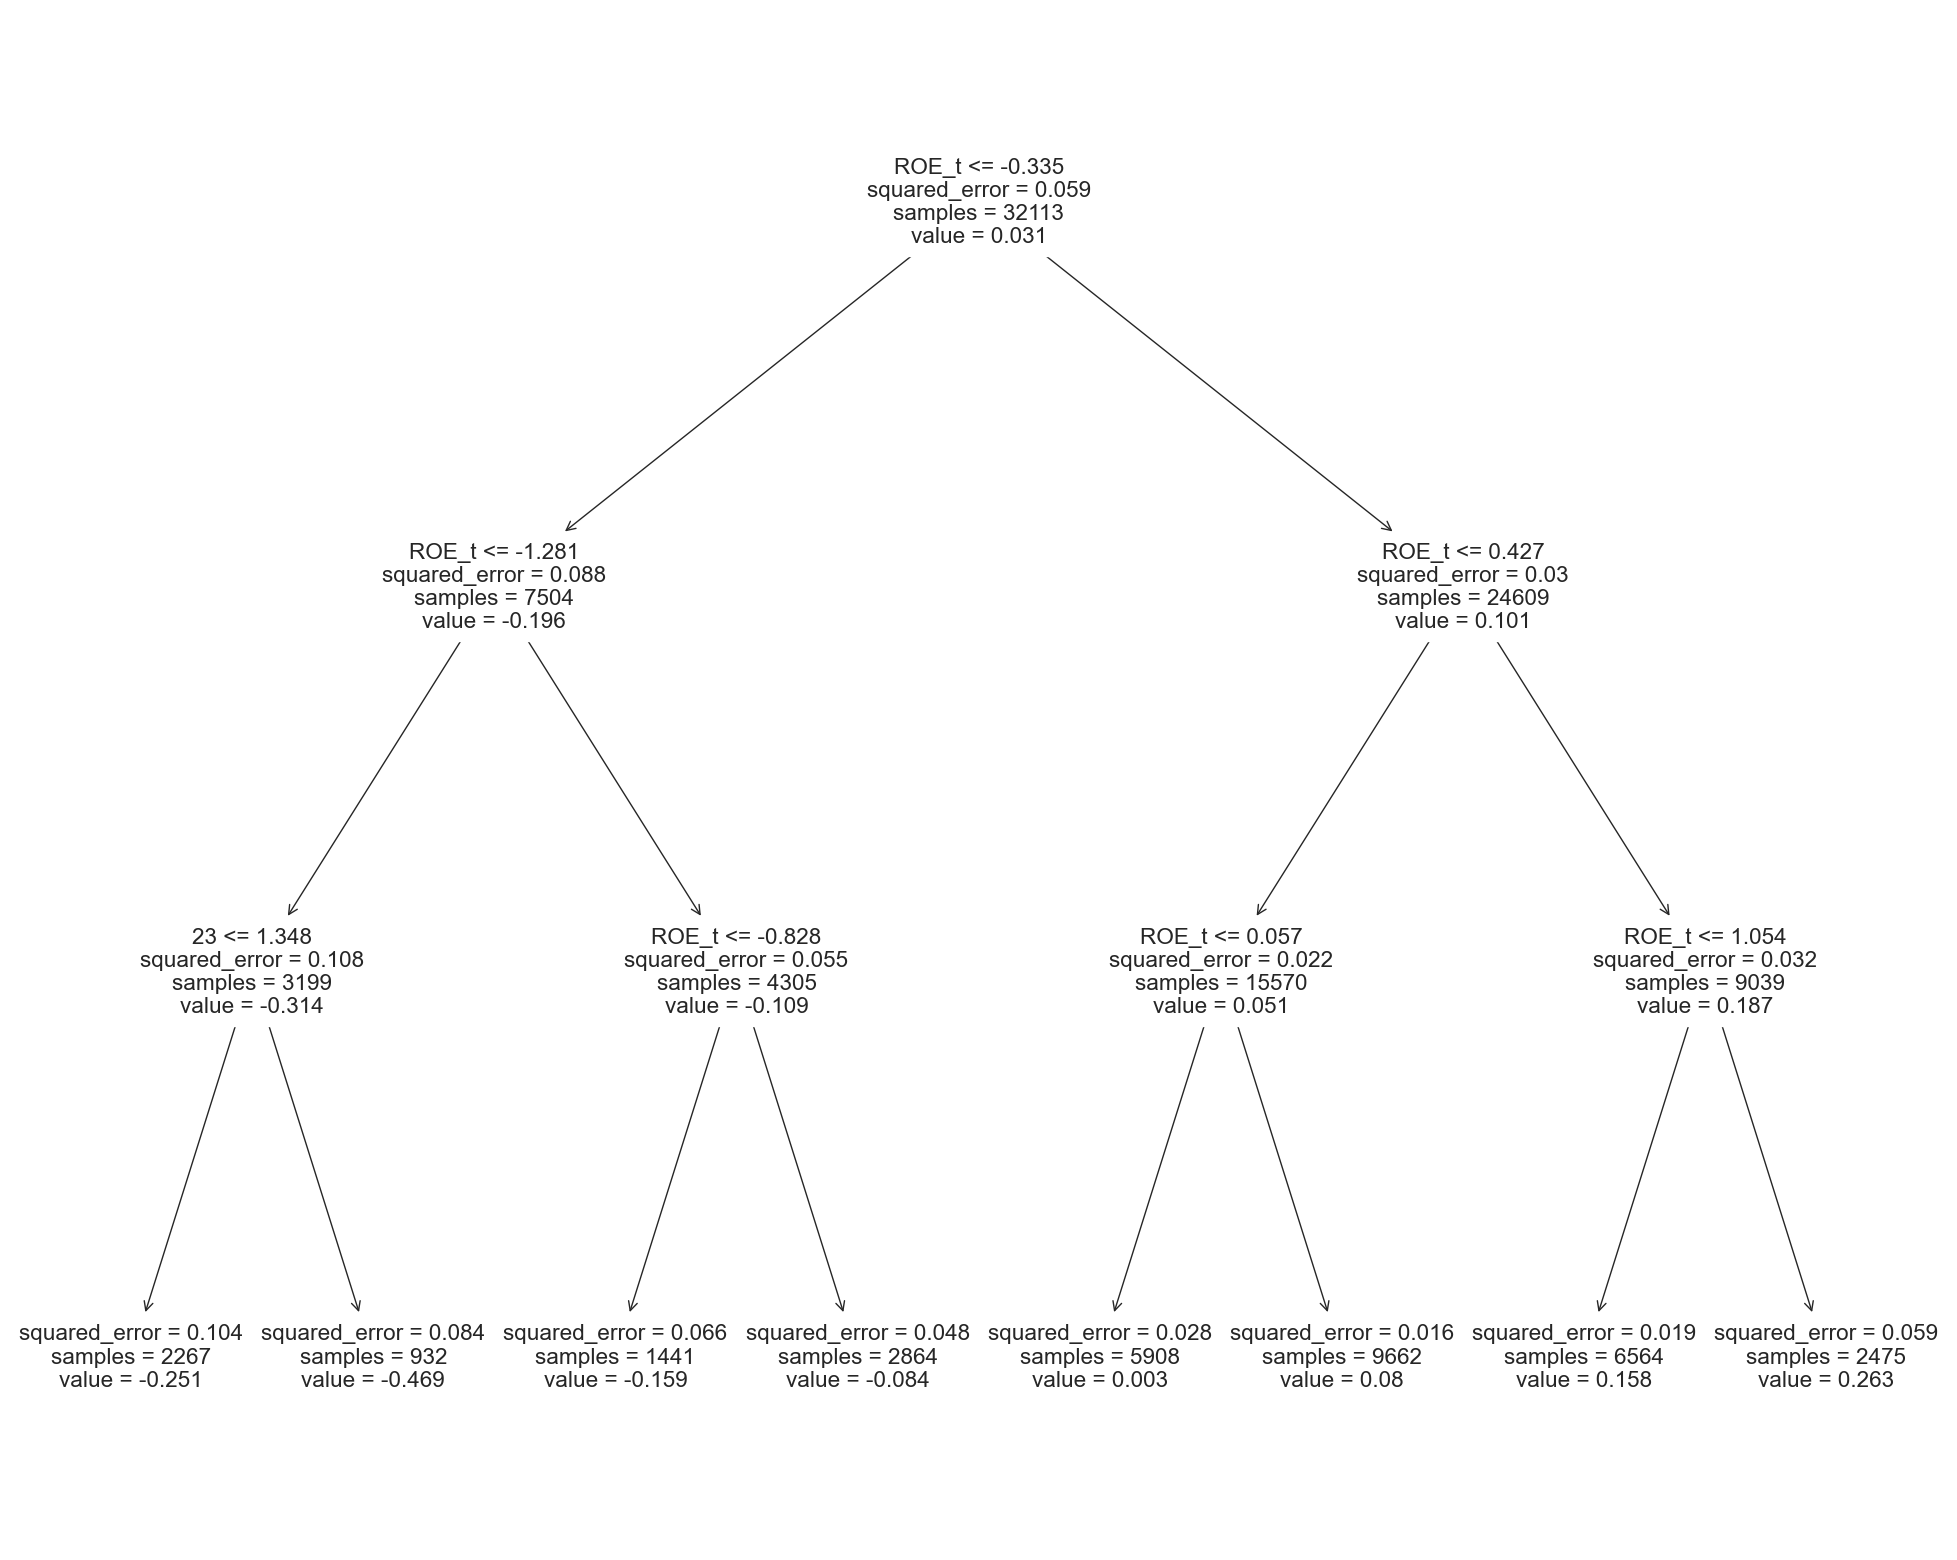

In [121]:
fig = plt.figure(figsize=(25,20))

features_names = np.append(np.arange(1, 101), 'ROE_t')
_ = tree.plot_tree(model1_2_dt, feature_names=features_names)

In [77]:
get_test_mse(model1_2_dt,
             test_features_m1_2_norm,
             test_label_m1_2)

0.039247112551174065

In [78]:
# tune hyperparameters
dt_params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [10, 20, 50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'splitter': ['best', 'random']
}

model1_2_dt_tune = GridSearchCV(estimator=model1_2_dt,
                           param_grid=dt_params,
                           n_jobs=-1)
model1_2_dt_tune.fit(train_features_m1_2_norm, train_label_m1_2)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/l

GridSearchCV(estimator=DecisionTreeRegressor(max_depth=3), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [10, 20, 50, 100, 200],
                         'splitter': ['best', 'random']})

In [79]:
model1_2_dt_tune.best_params_

{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 50,
 'splitter': 'best'}

In [80]:
model1_2_dt_best = model1_2_dt_tune.best_estimator_
model1_2_dt_best_mse = get_test_mse(model1_2_dt_best,
             test_features_m1_2_norm,
             test_label_m1_2)
model1_2_dt_best_mse

0.03832947306114129

In [82]:
pickle.dump(model1_2_dt_best, open('finalised-models/model1-2-dt.pkl', 'wb'))

In [11]:
model1_2_dt_pkl = pickle.load(open('finalised-models/model1-2-dt.pkl', 'rb'))

In [32]:
print('MAE: ', get_test_mae(
    model1_2_dt_pkl,
    test_features_m1_2_norm,
    test_label_m1_2
))

n = test_data.shape[0]
p = test_features_m1_2.shape[1]
print('Adjusted R^2: ', get_test_adj_r2(
    model1_2_dt_pkl,
    test_features_m1_2_norm,
    test_label_m1_2,
    n,
    p
))

MAE:  0.12093122500554479
Adjusted R^2:  0.403435254888439


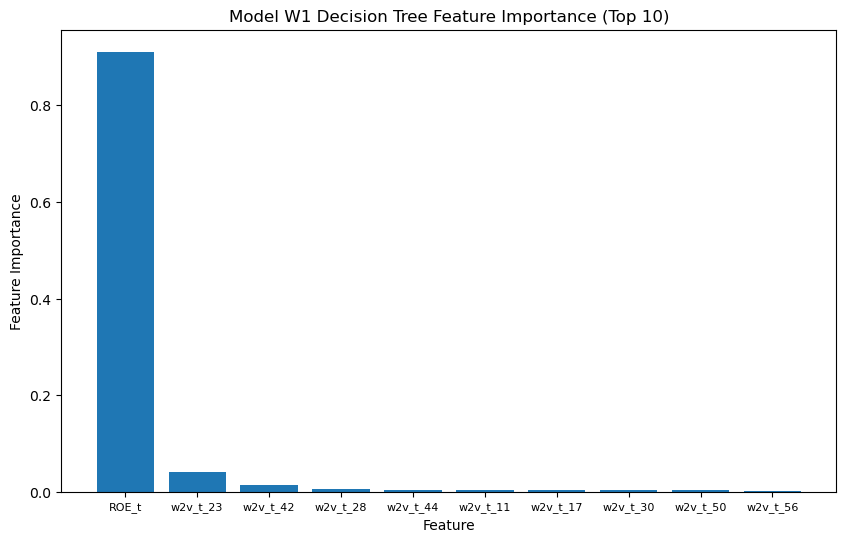

In [12]:
feature_importances = model1_2_dt_pkl.feature_importances_
feature_names = [f"w2v_t_{i}" for i in range(1, 101)] + ['ROE_t']

sorted_indices = np.argsort(feature_importances)[::-1]

sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_feature_importances = feature_importances[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(0, 10), sorted_feature_importances[:10])
plt.xticks(range(0, 10), sorted_feature_names[:10], fontsize=8)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Model W1 Decision Tree Feature Importance (Top 10)')
plt.show()

Model1.2 Gradient boosting

In [14]:
model1_2_gb = GradientBoostingRegressor()

In [15]:
# with default parameters
model1_2_gb.fit(train_features_m1_2_norm, train_label_m1_2)

GradientBoostingRegressor()

In [16]:
get_test_mse(model1_2_gb,
             test_features_m1_2_norm,
             test_label_m1_2)

0.037270481436514215

In [24]:
# tune hyperparameters
gb_params = {
    'n_estimators': [50, 100, 150],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [3, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10, 20, 50, 100],
    'min_samples_leaf': [1, 5, 10, 20, 50, 100],
    'learning_rate': [0.1, 0.01, 0.001]
}

# use RandomizedSearchCV for save computation
model1_2_gb_tune = RandomizedSearchCV(estimator=model1_2_gb,
                                param_distributions=gb_params,
                                random_state=42,
                                n_iter=100,
                                n_jobs=-1)
model1_2_gb_tune.fit(train_features_m1_2_norm, train_label_m1_2)

RandomizedSearchCV(estimator=GradientBoostingRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.01, 0.001],
                                        'max_depth': [3, 5, 10, 20, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 5, 10, 20, 50,
                                                             100],
                                        'min_samples_split': [2, 5, 10, 20, 50,
                                                              100],
                                        'n_estimators': [50, 100, 150]},
                   random_state=42)

In [25]:
model1_2_gb_tune.best_params_

{'n_estimators': 150,
 'min_samples_split': 10,
 'min_samples_leaf': 100,
 'max_features': 'sqrt',
 'max_depth': 5,
 'learning_rate': 0.1}

In [28]:
model1_2_gb_best = model1_2_gb_tune.best_estimator_
get_test_mse(model1_2_gb_best,
             test_features_m1_2_norm,
             test_label_m1_2)

0.03700299138015559

In [30]:
# save the best gb model as binary file
pickle.dump(model1_2_gb_best, open('finalised-models/model1-2-gb-best.pkl', 'wb'))

In [13]:
# reload best gt model to calculate MAE and adjusted R^2
w2v_best = pickle.load(open('finalised-models/model1-2-gb-best.pkl', 'rb'))

In [12]:
get_test_mae(w2v_best, test_features_m1_2_norm, test_label_m1_2)

0.11936221654099377

In [13]:
n = len(test_features_m1_2_norm)
p = train_features_m1_2_norm.shape[1]
get_test_adj_r2(
    w2v_best,
    test_features_m1_2_norm,
    test_label_m1_2,
    n,
    p
)

0.424080782799822

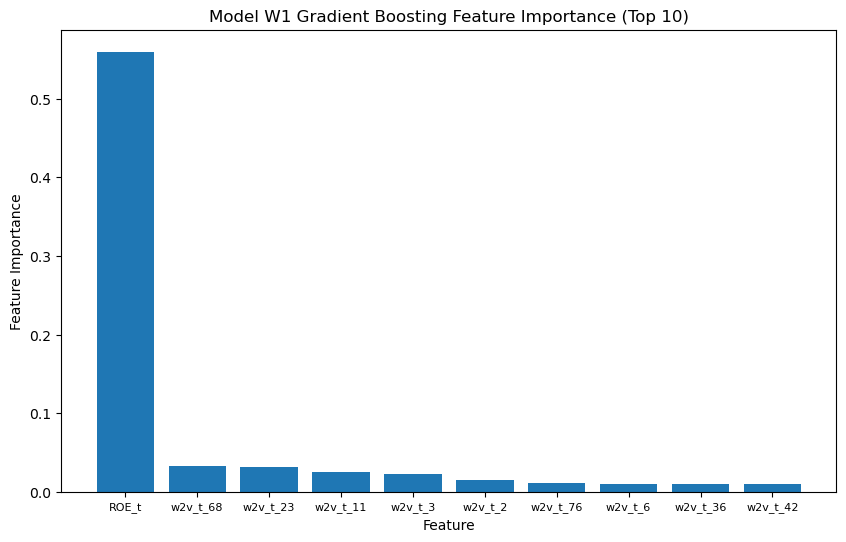

In [14]:
feature_importances = w2v_best.feature_importances_
feature_names = [f"w2v_t_{i}" for i in range(1, 101)] + ['ROE_t']

sorted_indices = np.argsort(feature_importances)[::-1]

sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_feature_importances = feature_importances[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(0, 10), sorted_feature_importances[:10])
plt.xticks(range(0, 10), sorted_feature_names[:10], fontsize=8)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Model W1 Gradient Boosting Feature Importance (Top 10)')
plt.show()

In [32]:
w2v_best.feature_importances_

array([3.46706990e-03, 1.44402138e-02, 2.25525055e-02, 1.22384591e-03,
       4.25032474e-04, 1.02027831e-02, 1.79906289e-03, 1.16010952e-03,
       9.41892263e-04, 8.19923344e-04, 2.48261857e-02, 8.08357290e-03,
       1.99817033e-03, 7.41408263e-04, 2.89950331e-03, 1.75581627e-03,
       3.52286441e-03, 5.98263378e-03, 8.96847204e-03, 1.89884506e-03,
       1.47367934e-03, 1.68421947e-03, 3.18076625e-02, 4.90690956e-04,
       1.31499058e-03, 3.77605848e-03, 6.59926997e-04, 4.10385542e-03,
       2.11756541e-03, 1.41790734e-03, 9.20269741e-04, 6.57989838e-03,
       4.46765149e-03, 3.10507153e-03, 3.41684054e-03, 9.92825065e-03,
       6.41937755e-03, 1.78041192e-03, 2.29036669e-03, 2.29674353e-03,
       4.53367392e-03, 9.65592210e-03, 8.99911562e-03, 3.30364529e-03,
       2.12721672e-03, 6.17770964e-03, 1.20048380e-03, 4.92849912e-03,
       1.65552174e-03, 7.12298329e-03, 9.72876131e-04, 2.80907354e-03,
       1.26266798e-03, 1.80162557e-03, 3.40909792e-03, 3.63643964e-03,
      